# TP4 - Grupo 14

André Lucena Ribas Ferreira - A94956

Paulo André Alegre Pinto - A97391

# Enunciado do Problema 1

![](https://paper-attachments.dropboxusercontent.com/s_9896551CC5FAD2B2EB6E4EBC08522545FA66314D29FE6A5BE8E593259F8E8A37_1672830059198_ABS.png)

![](https://paper-attachments.dropboxusercontent.com/s_C5426E33053EA04D1E3446B871CC8485C43045FF7CAAA1FC86A9B3A8E09058F9_1574702123197_Documento.png)

# Análise

O objetivo de um sistema ABS é de evitar que as rodas de um carro bloqueiem quando uma travagem brusca ocorre. Neste caso, a travagem é tal que a única força exercida no sistema é a de atrito, seja entre o corpo e as rodas como as rodas e o solo.

## Constantes
 - $a_1$ $\rightarrow$ atrito no modo `BLOCKED`;
 - $a_2$ $\rightarrow$ atrito nos restentas modos;
 - $c_1$ $\rightarrow$ constante de proporcionalidade na travagem do modo `STOPPING`;
 - $c_2$ $\rightarrow$ constante de proporcionalidade na travagem do modo `FREE`;
 - $P$ $\rightarrow$ peso do veículo em Newtons;
 - $v_i$ $\rightarrow$ velocidade inicial do veículo em metros/segundo;
 - $\tau \rightarrow$ limite máximo de tempo nos modos `FREE` e `BLOCKED`;
 - $e \rightarrow$ diferença entre $V$ e $R$ que bloqueia as rodas.
 
## Variáveis Contínuas
 - $T$ $\rightarrow$ tempo em segundos;
 - $V$ $\rightarrow$ velocidade do veículo em metros/segundo;
 - $R$ $\rightarrow$ velocidade das rodas em metros/segundo;
 - $Timer$ $\rightarrow$ Timer utilizado nos modos `BLOCKED` e `FREE`.
 
## Variáveis Discretas
 - $M$ $\rightarrow$ Modo de execução.

## Relações Diferenciais, por modo

### Start
 - $T = 0$, $V = v_i$ e $R = v_i$

### Free
 - $\dot{V} = -c_2(V-R)$
 - $\dot{R} = -a_2 * P + c_2(V-R)$
 - $V \geq 0$ e $R \geq 0$
 - $V - R \geq 0$
 
### Stopping
 - $\dot{V} = -c_1(V-R)$
 - $\dot{R} = -a_2 * P + c_1(V-R)$
 - $V \geq 0$ e $R \geq 0$
 - $V - R \geq 0$
 - $V - R \geq e$
 
### Blocked
 - $V = R$
 - $\dot{R} = -a_1 * P$
 - $V \geq 0$ e $R \geq 0$
 - $V - R \geq 0$
 
### Stopped
 - $V = 0$ e $R = 0$

## Switches

### Start $\rightarrow$ Free
 - Sem condição;
 - Colocar $Timer = 0$.
 
### Free $\rightarrow$ Stopping
 - $Timer \geq \tau$.
 
### Stopping $\rightarrow$ Blocked
 - $V - R < e$;
 - Colocar $Timer = 0$.
 
### Blocked $\rightarrow$ Free
 - $Timer \geq \tau$;
 - Colocar $Timer = 0$.
 
### Stopping $\rightarrow$ Stopped
 - $V = 0$ e $R = 0$.

## Modelação em LT das propriedades que garantem comportameneto desejável

O veículo imobiliza-se completamente em menos de $t$ segundos.
 - $T \geq t \implies M == 4$
 
A velocidade diminui sempre com o tempo.
 - $T' > T \implies V' < V$

# Implementação

Para a resolução do problema em questão, decidiu-se usar o módulo `pysmt.shortcuts`, com as funcionalidades possíveis para a utilização de um SMT Solver. Importam-se também os tipos deste Solver, a partir do módulo `pysmt.typing`.

In [1]:
from z3 import *
from pysmt.shortcuts import *
import pysmt.typing
import itertools
import matplotlib.pyplot as plt
from math import ceil

Enunciam-se os valores enumerados para cada um dos Modos de execução.
 - Init $\rightarrow$ 0
 - Free $\rightarrow$ 1
 - Stopping $\rightarrow$ 2
 - Blocked $\rightarrow$ 3
 - Stopped $\rightarrow$ 4

## Gráfico

In [2]:
def simulation(a1, a2, c1, c2, dt, e, P, tau, time, vi):
    v = vi
    r = vi
    t = 0
    V = [v]
    R = [r]
    T = [t]
    timer = 0
    m = 1
    
    while(t<time and (v>0 or r>0)):
        
        if m == 2 and (v - r < e )  :
            m = 3
        
        elif timer >= tau and m == 3:
            m = 1
            timer = 0
        
        elif timer >= tau and m == 1:
            m = 2
            timer = 0 
        
        if m == 1:
            v, r = v + (-c2*(v-r))*dt, r + (-a2*P + c2*(v-r))*dt
        elif m == 2:
            v, r = v + (-c1*(v-r))*dt, r + (-a2*P + c1*(v-r))*dt
        else:
            v, r = r + (-a1*P)*dt,     r + (-a1*P)*dt 
        
        if v < 0:
            v = 0
        if r < 0:
            r = 0
        t += dt
        timer += dt
        V.append(v)
        R.append(r)
        T.append(t)
        
    plt.plot(T,V,T,R)
    plt.title("Velocidade pelo Tempo")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Velocidade (m/s)")
    plt.legend(["Veiculo", "Rodas"], loc ="upper right")
    plt.grid(True)

In [3]:
a1 = 0.001
a2 = 0.01 #coeficiente de atrito com uma estrada normal é de 0.7
c1 = 30
c2 = 0.5
dt = 0.01
e = 0.5
P = 1300 #peso médio de um carro é de 1302 kilos mas faltam aqui 9.8 m/s^2
tau = 0.5
time = 6
vi = 20

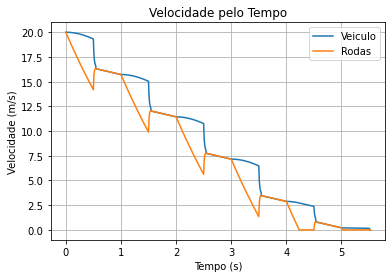

In [4]:
simulation(a1, a2, c1, c2, dt, e, P, tau, time, vi)

O "Timer" definido para o estado `BLOCKED` e `FREE` deve ser uma variável global do sistema que limita a sua operabilidade.

In [5]:
timer = 3

Declaram-se as variáveis para cada um dos estados.

In [6]:
vars = ['T','V','R','M','Timer']
def declare(S,i):
    s = {}
    s['T'] = Symbol('T'+S+str(i), REAL)
    s['V'] = Symbol('V'+S+str(i), REAL)
    s['R'] = Symbol('R'+S+str(i), REAL)
    s['M'] = Symbol('M'+S+str(i), INT)
    #s['c'] = Symbol('c'+S+str(i), REAL)
    s['Timer'] = Symbol('Timer'+S+str(i), REAL)
    return s

Define-se o predicado Inicial. Note-se a não necessidade de manipular a variável `Timer` quando esta não tem utilidade.

In [7]:
def init(s, vi):
    return And(Equals(s['T'], Real(0)), Equals(s['V'], Real(vi)), Equals(s['R'], Real(vi)), Equals(s['M'], Int(0)))

### Discretização das Relações

Para se evitar Trajetórias de Zenão, obriga-se que a diferença entre os tempos seja maior que uma constante $dt$.

Também na Discretização das Relações, o fator $(V - R)$ terá de ser aproximado por uma constante, para não existir multiplicação de variáveis. Para tal, pode-se ter em conta intervalos de velocidades para aproximar a diferença. Tem-se as seguintes limitações base:

$$ 0 \leq (V-R) \leq v_i $$

Mas a diferença entre $V$ e $R$ nunca será maior que a diferença maior calculada entre as duas variáveis no decorrer do modo `FREE`, que demora sempre, no máximo, $tau$ segundos e que começa sempre com $V = R$. Como tal, o limite máximo será:

$$ V - R \equiv a_2 * P * \tau$$

Podendo então considerar uma aproximação $b$ no intervalo, com um diferença de $0.5$:

$$ b \in [0,0.5,1,...,\tau] $$

### Free $\rightarrow$ Free

$$ V' - V = (-c_2*b)*(T'-T) $$
$$ R' - R = (-a_2*P + c_2*b)*(T'-T) $$

### Stopping $\rightarrow$ Stopping

$$ V' - V = (-c_1*b)*(T'-T) $$
$$ R' - R = (-a_2*P + c_1*b)*(T'-T) $$

### Blocked $\rightarrow$ Blocked

$$ V = R $$
$$ R' - R = (-a_1*P)*(T'-T) $$

In [28]:
disc = []
i = 0
while i<=a2*P*tau:
    disc.append(i)
    i += 0.5
    
dt = 0.01
    
def trans(s, p):
    
    #untimed
    startToFree = And(Equals(s['M'],Int(0)), Equals(p['M'],Int(1)), Equals(s['T'],p['T']), Equals(s['V'],p['V']), Equals(s['R'],p['R']),
                         Equals(p['Timer'], Real(0)))
    
    stoppingToBlocked = And(Equals(s['M'],Int(2)), Equals(p['M'],Int(3)), Equals(s['T'],p['T']), s['V']>0, s['R']>=0, 
                            Equals(s['V'],p['V']), Equals(s['R'],p['R']), Equals(p['Timer'],Real(0)), s['V']-s['R']<e)
    
    blockedToFree = And(Equals(s['M'],Int(3)), Equals(p['M'],Int(1)) ,Equals(s['T'],p['T']),s['V']>=0,s['R']>=0, 
                       Equals(s['V'],p['V']), Equals(s['R'],p['R']), s['Timer']>=tau, 
                       Equals(p['Timer'],Real(0)))
    
    
    freeToStopping  =  And(Equals(s['M'],Int(1)), Equals(p['M'],Int(2)) ,Equals(s['T'],p['T']), s['V']>=0,s['R']>=0, 
                          Equals(s['V'],p['V']), Equals(s['R'],p['R']), s['Timer']>=tau)
    
    
    stoppingToStopped = And(Equals(s['M'],Int(2)), Equals(p['M'],Int(4)) ,Equals(s['T'],p['T']),
                           s['V']<e, s['R']<e, Equals(p['V'], Real(0)), Equals(p['R'], Real(0)))
    
    stoppedToStopped = And(Equals(s['M'],Int(4)), Equals(p['M'],Int(4)), Equals(s['T'] , p['T']), 
                          Equals(s['V'],p['V']), Equals(s['R'], p['R']))
    
    #timed
    freeToFree = Or([And(Equals(s['M'],Int(1)),Equals(p['M'],Int(1)),p['T'] - s['T'] > dt, s['V']>=0,s['R']>=0,
                        p['V']>=0, p['R']>=0, 
                        p['Timer']<=tau,Equals(p['Timer'],s['Timer']+p['T']-s['T']), 
                        s['V']-s['R']<b+0.5, s['V']-s['R']>=b-0.5, 
                        Equals(p['V'],(s['V']+(-c2*b)*(p['T']-s['T']))),
                        Equals(p['R'],(s['R']+(-a2*P + c2*b)*(p['T']-s['T']))))for b in disc])
    
    stoppingToStopping = Or([And(Equals(s['M'],Int(2)),Equals(p['M'],Int(2)),p['T'] - s['T'] > dt,
                        s['V']-s['R']>=e, p['V']-p['R']>=0,   
                        s['V']>=0,s['R']>=0, p['V']>=0, p['R']>=0,
                        s['V']-s['R']<b+0.5, s['V']-s['R']>=b-0.5, 
                        Equals(p['V'],(s['V']+(-c1*b)*(p['T']-s['T']))),
                        Equals(p['R'],(s['R']+(-a2*P + c1*b)*(p['T']-s['T']))))for b in disc])
    
    blockedToBlocked = And(Equals(s['M'],Int(3)),Equals(p['M'],Int(3)),p['T'] - s['T']> dt,s['V']>=0,s['R']>=0,
                          p['V']>=0, p['R']>=0, 
                          p['Timer']<=tau,Equals(p['Timer'],s['Timer']+p['T']-s['T']),
                          Equals(p['V'], p['R']), 
                          Equals(p['R'], s['R'] + (-a1*P)*(p['T']-s['T']))) 
    
    return Or(startToFree, stoppingToBlocked, blockedToFree, freeToStopping, stoppingToStopped, stoppedToStopped,
              freeToFree, stoppingToStopping, blockedToBlocked)

In [31]:
def genTrace(vars,init,trans,n):
    with Solver(name="z3") as solver:
        X = [declare('X',i) for i in range(n+1)]   # cria n+1 estados (com etiqueta X)
        I = init(X[0],vi)
        Tks = [ trans(X[i],X[i+1]) for i in range(n) ]
        if solver.solve([I,And(Tks)]):      # testa se I /\ T^n  é satisfazível
            for i in range(n+1):
                print("Estado:",i)
                for v in X[i]:
                    print("          ",v,'=',float(solver.get_py_value(X[i][v])))
        else:
            print("Help!")

In [32]:
genTrace(vars, init, trans, 30)

Estado: 0
           T = 0.0
           V = 20.0
           R = 20.0
           M = 0.0
           Timer = 0.0
Estado: 1
           T = 0.0
           V = 20.0
           R = 20.0
           M = 1.0
           Timer = 0.0
Estado: 2
           T = 0.038427526179564755
           V = 20.0
           R = 19.50044215966566
           M = 1.0
           Timer = 0.038427526179564755
Estado: 3
           T = 0.07688906464110322
           V = 20.0
           R = 19.00044215966566
           M = 1.0
           Timer = 0.07688906464110322
Estado: 4
           T = 0.4433553095024555
           V = 19.90838343878466
           R = 14.327997537683416
           M = 1.0
           Timer = 0.4433553095024555
Estado: 5
           T = 0.4895578403343418
           V = 19.781326478996974
           R = 13.854421596656582
           M = 1.0
           Timer = 0.4895578403343418
Estado: 6
           T = 0.5
           V = 19.75
           R = 13.75
           M = 1.0
           Timer = 0.5
Estado: 7
    

In [33]:
def genTraceEnd(vars,init,trans,n):
    with Solver(name="z3") as solver:
        X = [declare('X',i) for i in range(n+1)]   # cria n+1 estados (com etiqueta X)
        I = init(X[0],vi)
        Tks = [ trans(X[i],X[i+1]) for i in range(n) ]
        End = Equals(X[-1]['M'], Int(4))
        if solver.solve([I,And(Tks),End]):      # testa se I /\ T^n  é satisfazível
            for i in range(n+1):
                print("Estado:",i)
                for v in X[i]:
                    print("          ",v,'=',float(solver.get_py_value(X[i][v])))
        else:
            print("A execução não termina em", n, "passos.")

In [ ]:
genTraceEnd(vars, init, trans, 35)

In [13]:
def bmc_always(declare,init,trans,inv,end,time,K):
    for k in range(1,K+1):
        with Solver(name="z3") as solver:
            trace = [declare('X',i) for i in range(k)]
            solver.add_assertion(init(trace[0], vi))
            for i in range(k-1):
                solver.add_assertion(trans(trace[i],trace[i+1]))
                solver.add_assertion(Not(inv(trace[i],trace[i+1])))
            solver.add_assertion(Not(end(trace[-1],time)))
            if solver.solve():
                print(f"As propriedades não são validas para o seguinte traço de tamanho <= %d" % k)
                i = 0
                for traco in trace:
                    print("Estado:",i)
                    i+=1
                    for v in traco:
                        print("          ",v,'=',float(solver.get_py_value(traco[v])))
                #return
    print(f"Propriedades válida para traços de tamanho <= %d." % k)

In [14]:
def testStop(state,time):
    return Implies(state['T']>=Real(time), Or(Equals(state['M'],Int(4)),And(state['V']<=Real(0),state['R']<=Real(0))))

def inv(pre,pos):
    return Implies(pre['T']<pos['T'],pre['V']>pos['V'])

In [15]:
bmc_always(declare,init,trans,inv,testStop,10,10)

Propriedades válida para traços de tamanho <= 10.
